# **Install and Import**

In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 20 03:18:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
!pip install -qqq transformers==4.28.1 --progress-bar off
!pip install -qqq bitsandbytes==0.38.1 --progress-bar off
!pip install -qqq accelerate==0.18.0 --progress-bar off
!pip install -qqq sentencepiece==0.1.99 --progress-bar off

In [ ]:
# !pip install fschat

In [5]:
!pip install torch
!pip install transformers

In [7]:
!pip install -U pip
!pip install accelerate==0.19.0
!pip install appdirs==1.4.4
!pip install bitsandbytes==0.37.2
!pip install datasets==2.10.1
!pip install fire==0.5.0
!pip install git+https://github.com/huggingface/peft.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install torch==2.0.0
!pip install sentencepiece==0.1.97
!pip install tensorboardX==2.6
!pip install gradio==3.23.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-hib4av2l
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-hib4av2l
  Resolved https://github.com/huggingface/peft.git to commit 4fd374e80d670781c0d82c96ce94d1215ff23306
 

In [8]:
import json
import textwrap
import torch
import os
import sys
import fire
import gradio as gr
import torch
import transformers
from peft import PeftModel
from transformers import GenerationConfig, LlamaForCausalLM, LlamaTokenizer
from transformers import Trainer


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /usr/lib64-nvidia did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('//172.28.0.1'), PosixPath('8013')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc48301118ce562b961b3c22d803539adc1e0c19/gpu-a100-s-3u

In [9]:
from typing import List

from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
)

import fire
import torch
from datasets import load_dataset
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import json

%matplotlib inline
sns.set(rc={'figure.figsize':(8, 6)})
sns.set(rc={'figure.dpi':100})
sns.set(style='white', palette='muted', font_scale=1.2)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

# **Vicuna Model**

In [10]:
MODEL_NAME = "TheBloke/vicuna-7B-1.1-HF"
tokenizer = LlamaTokenizer.from_pretrained(MODEL_NAME)

model = LlamaForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    load_in_8bit=True,
    device_map="auto",
    offload_folder="./cache",
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
BASE_MODEL = "TheBloke/vicuna-7B-1.1-HF"
model = LlamaForCausalLM.from_pretrained(BASE_MODEL, load_in_8bit=True, torch_dtype=torch.float16,device_map="auto", offload_folder="./cache")
tokenizer = LlamaTokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token_id = (0)
tokenizer.padding_side = "left"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
def format_prompt(prompt: str) -> str:
    text = f"""
### Human: {prompt}
### Assistant:
    """
    return text.strip()

#print(format_prompt("In which city is IU International of Applied Science Germany located? Reply in only 1 sentence."))

In [13]:
prompt = format_prompt("In which city is IU International of Applied Science Germany located? Reply in only 1 sentence. Don't generate any new question.")

In [14]:
generation_config = GenerationConfig(
    max_new_tokens=64,
    temperature=0.2,
    repetition_penalty=1.0,
)

In [15]:
inputs = tokenizer(
    prompt, padding=False, add_special_tokens=False, return_tensors="pt"
).to(model.device)

with torch.inference_mode():
    tokens = model.generate(**inputs, generation_config=generation_config)

In [16]:
completion = tokenizer.decode(tokens[0], skip_special_tokens=True)
print(completion)

### Human: In which city is IU International of Applied Science Germany located? Reply in only 1 sentence. Don't generate any new question.
### Assistant: The IU International of Applied Science Germany is located in Berlin.


In [17]:
def print_response(response: str):
    assistant_prompt = "### Assistant:"
    assistant_index = response.find(assistant_prompt)
    text = response[assistant_index + len(assistant_prompt) :].strip()
    print(textwrap.fill(text, width=110))

In [18]:
print_response(completion)

The IU International of Applied Science Germany is located in Berlin.


In [19]:
def generate_text(
    prompt: str,
    model: LlamaForCausalLM = model,
    tokenizer: LlamaTokenizer = tokenizer,
    generation_config: GenerationConfig = generation_config,
):
    prompt = format_prompt(prompt)

    inputs = tokenizer(
        prompt, padding=False, add_special_tokens=False, return_tensors="pt"
    ).to(model.device)

    with torch.inference_mode():
        tokens = model.generate(**inputs, generation_config=generation_config)
    return tokenizer.decode(tokens[0], skip_special_tokens=True)

In [20]:
%%time
response = generate_text("Who is Henny Purwadi? Reply in 1 sentence. DON'T generate other questions")
print_response(response)

Henny Purwadi is a person.
CPU times: user 1.82 s, sys: 0 ns, total: 1.82 s
Wall time: 1.82 s


# **Chatbot App**

#### This vicuna app is using this model: 
#### **https://huggingface.co/TheBloke/vicuna-7B-1.1-HF"**



In [21]:
import locale
print(locale.getpreferredencoding())

ANSI_X3.4-1968


In [22]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [23]:
import locale
print(locale.getpreferredencoding())

UTF-8


In [24]:
%%writefile app.py
import gradio as gr
import torch
from transformers import GenerationConfig, LlamaForCausalLM, LlamaTokenizer
from transformers import Trainer

BASE_MODEL = "TheBloke/vicuna-7B-1.1-HF"
model = LlamaForCausalLM.from_pretrained(BASE_MODEL, load_in_8bit=True, torch_dtype=torch.float16,device_map={0: [0, 1, 2], 1: [3, 4, 5]}, offload_folder="./cache")
tokenizer = LlamaTokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token_id = 0
tokenizer.padding_side = "left"

def format_prompt(prompt: str) -> str:
    return f"### Human: {prompt}\n### Assistant:"

generation_config = GenerationConfig(
    max_new_tokens=128,
    temperature=0.2,
    repetition_penalty=1.0,device_map = {0: [0, 1, 2], 1: [3, 4, 5]}

model = LlamaForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    load_in_8bit=True,
    device_map="auto",
    offload_folder="./cache",
)

tokenizer = LlamaTokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token_id = 0
tokenizer.padding_side = "left"

def format_prompt(prompt: str) -> str:
    return f"### Human: {prompt}\n### Assistant:"

generation_config = GenerationConfig(
    max_new_tokens=128,
    temperature=0.2,
    repetition_penalty=1.0,
)

def generate_text(prompt: str):
    formatted_prompt = format_prompt(prompt)

    inputs = tokenizer(
        formatted_prompt, 
        padding=False, 
        add_special_tokens=False, 
        return_tensors="pt"
    ).to(model.device)

    with torch.inference_mode():
        tokens = model.generate(**inputs, generation_config=generation_config)

    response = tokenizer.decode(tokens[0], skip_special_tokens=True)
    assistant_index = response.find("### Assistant:") + len("### Assistant:")
    return response[assistant_index:].strip()

iface = gr.Interface(
    fn=generate_text, 
    inputs="text", 
    outputs="text",
    title="Chatbot",
    description="This vicuna app is using this model: https://huggingface.co/TheBloke/vicuna-7B-1.1-HF"
)
iface.launch()

Writing app.py


In [25]:
import torch
from peft import PeftModel
import transformers
import gradio as gr
from transformers import GenerationConfig, LlamaForCausalLM, LlamaTokenizer
from transformers import Trainer

BASE_MODEL = "TheBloke/vicuna-7B-1.1-HF"

model = LlamaForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    load_in_8bit=True,
    device_map="auto",
    offload_folder="./cache",
)

tokenizer = LlamaTokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token_id = 0
tokenizer.padding_side = "left"

def format_prompt(prompt: str) -> str:
    return f"### Human: {prompt}\n### Assistant:"

generation_config = GenerationConfig(
    max_new_tokens=128,
    temperature=0.2,
    repetition_penalty=1.0,
)

def generate_text(prompt: str):
    formatted_prompt = format_prompt(prompt)

    inputs = tokenizer(
        formatted_prompt, 
        padding=False, 
        add_special_tokens=False, 
        return_tensors="pt"
    ).to(model.device)

    with torch.inference_mode():
        tokens = model.generate(**inputs, generation_config=generation_config)

    response = tokenizer.decode(tokens[0], skip_special_tokens=True)
    assistant_index = response.find("### Assistant:") + len("### Assistant:")
    return response[assistant_index:].strip()

iface = gr.Interface(
    fn=generate_text, 
    inputs="text", 
    outputs="text",
    title="Chatbot",
    description="This vicuna app is using this model: https://huggingface.co/TheBloke/vicuna-7B-1.1-HF"
)
iface.launch()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

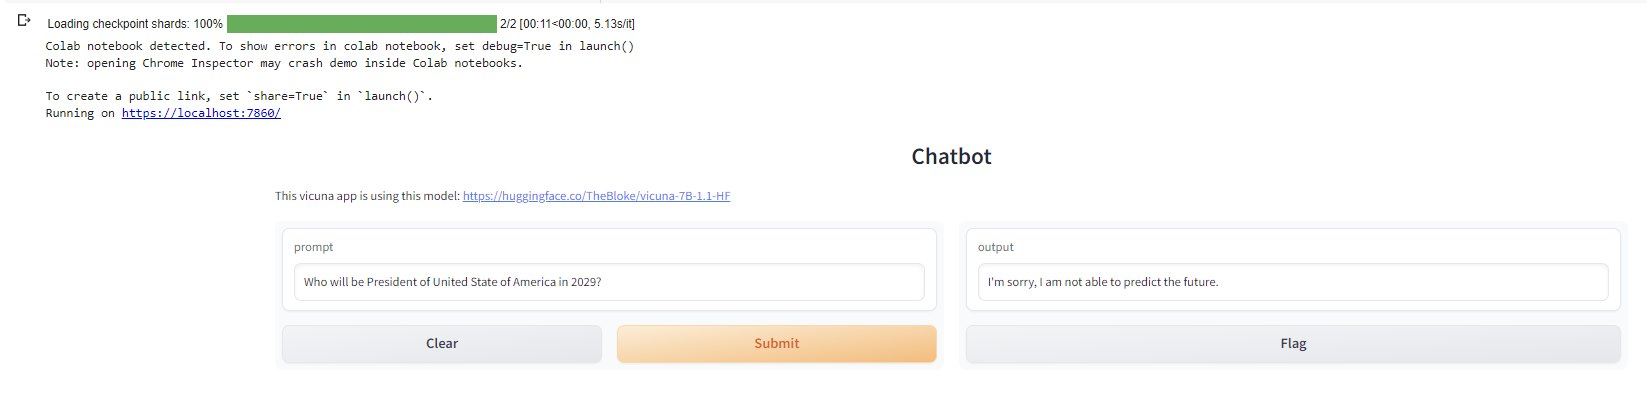